In [23]:
from glob import glob
from pathlib import Path
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import staintools
from tqdm.notebook import tqdm, trange

In [24]:
input_images_path = Path('../data/train_images')
input_masks_path = Path('../data/train_masks')

  0%|          | 0/25 [00:00<?, ?it/s]

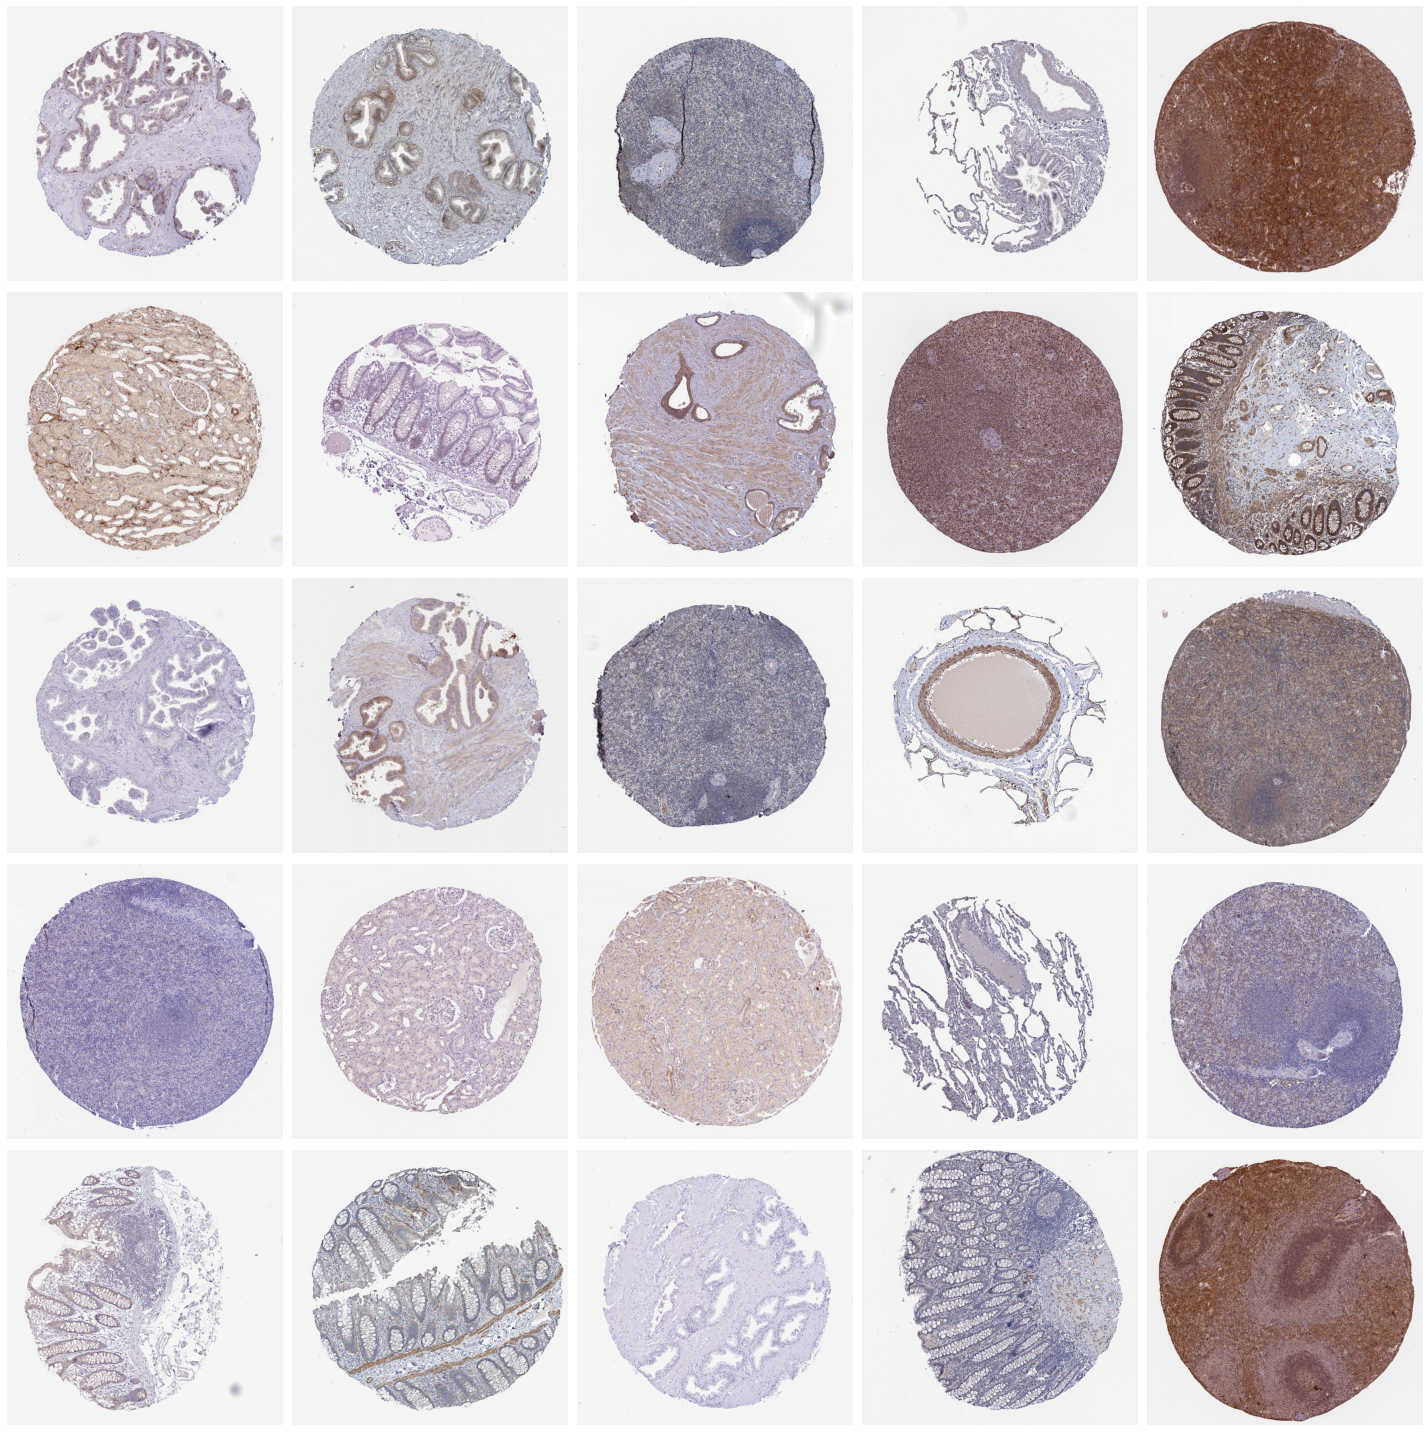

In [25]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for k, image_path in tqdm(enumerate(sorted(input_images_path.iterdir())[:25]), total=25):
    image = cv2.imread(str(image_path))[:, :, ::-1]
    i, j = k // 5, k % 5
    axs[i][j].imshow(image.astype(int))
    axs[i][j].axis('off')
plt.tight_layout()

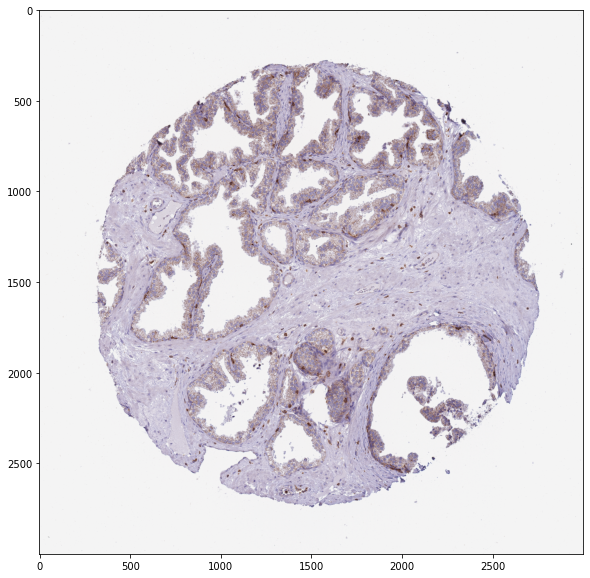

In [26]:
image = cv2.imread(str(input_images_path / '10044.tiff'))[:, :, ::-1]
plt.figure(figsize=(10, 10))
plt.imshow(image);

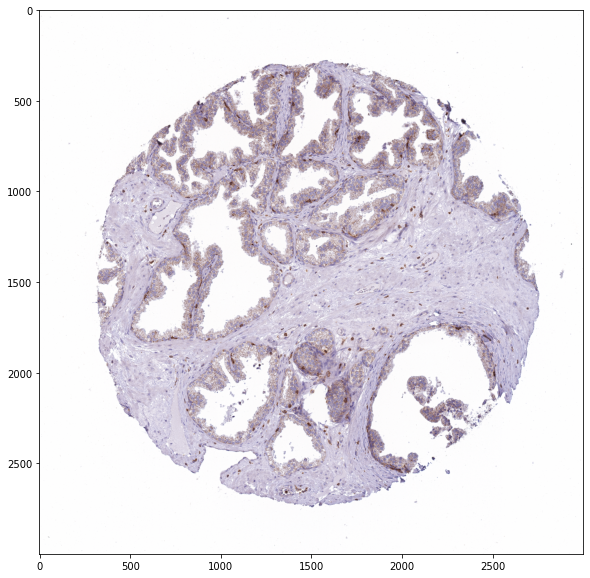

In [6]:
norm_image = staintools.LuminosityStandardizer.standardize(image)
plt.figure(figsize=(10, 10))
plt.imshow(norm_image);

In [12]:
augmentor = staintools.StainAugmentor(method='vahadane', sigma1=0.6, sigma2=0.6, augment_background=False)
augmentor.fit(norm_image)
aug_images = []
for _ in tqdm(range(25)):
    aug_image = augmentor.pop()
    aug_images.append(aug_image)

  0%|          | 0/25 [00:00<?, ?it/s]

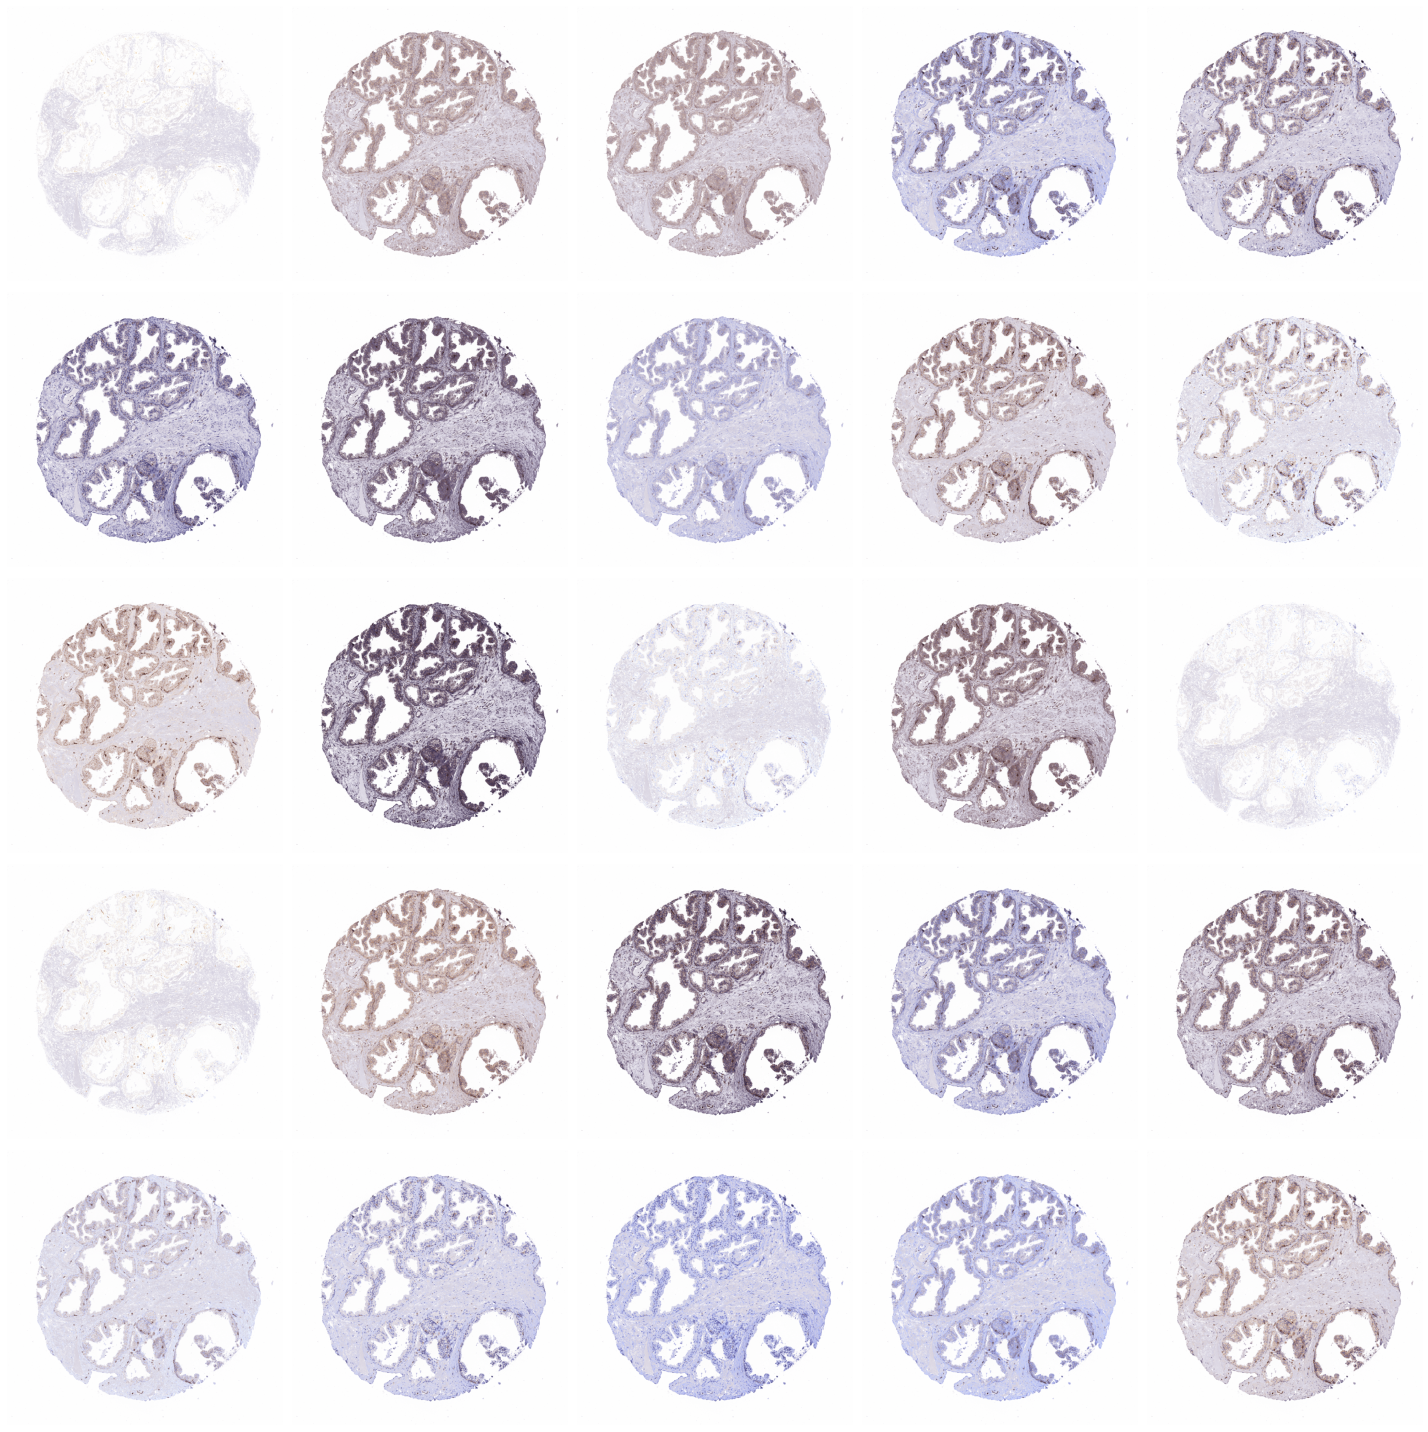

In [13]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for k, aug_image in enumerate(aug_images):
    i, j = k // 5, k % 5
    axs[i][j].imshow(aug_image.astype(int))
    axs[i][j].axis('off')
plt.tight_layout()

In [9]:
output_images_path = Path('../data/train_images_patches_768_overlap_stain_aug')
output_masks_path = Path('../data/train_masks_patches_768_overlap_stain_aug')
output_images_path.mkdir(exist_ok=True)
output_masks_path.mkdir(exist_ok=True)

In [43]:
SCALE_FACTOR = 0.5
PATCH_SIZE = 768
NUM_AUGS = 10
SIGMA1 = 0.6
SIGMA2 = 0.6

augmentor = staintools.StainAugmentor(
    method='vahadane', 
    sigma1=SIGMA1, 
    sigma2=SIGMA2, 
    augment_background=False
)


def patchify_image(id: str):    
    image_path = str(input_images_path / f'{id}.tiff')
    mask_path = str(input_masks_path / f'{id}.npy')
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = np.load(mask_path)
    
    img = cv2.resize(img, None, fx=SCALE_FACTOR, fy=SCALE_FACTOR, interpolation=cv2.INTER_AREA)
    mask = cv2.resize(mask, dsize=img.shape[:2], interpolation=cv2.INTER_NEAREST)
    
    img = staintools.LuminosityStandardizer.standardize(img)
    
    thresh = img.mean(axis=2).astype(np.uint8)
    
    color = np.array([255, 255, 255])
    img = np.stack([
        np.pad(img[:,:,c], PATCH_SIZE // 8, mode='constant', constant_values=color[c]) 
        for c in range(3)
    ], axis=2)

    color = np.array([0, 0, 0])
    mask = np.pad(mask, PATCH_SIZE // 8, mode='constant', constant_values=color[0])
    
    thresh = np.pad(thresh, PATCH_SIZE // 8, mode='constant', constant_values=255)
    _, thresh = cv2.threshold(thresh, int(thresh.mean()), 255, cv2.THRESH_BINARY)
    
    H, W, _ = img.shape
    
    patch_index = 0
    for dy in range(0, H - PATCH_SIZE, PATCH_SIZE // 4):
        for dx in range(0, W - PATCH_SIZE, PATCH_SIZE // 4):
            th_slc = thresh[dy : dy + PATCH_SIZE, dx : dx + PATCH_SIZE]
            th_slc = 1 - th_slc / 255
            th_sum = th_slc.sum()
            if th_sum < 1000:
                continue
            
            
            patch = img[dy : dy + PATCH_SIZE, dx : dx + PATCH_SIZE]
            maskpatch = mask[dy : dy + PATCH_SIZE, dx : dx + PATCH_SIZE]
            
            augmentor.fit(patch)
            for i in range(NUM_AUGS):
                aug_patch = augmentor.pop().astype(int)
                cv2.imwrite(str(output_images_path / '{}_{:05d}_{:02d}.png'.format(id, patch_index, i)), aug_patch[:, :, ::-1])
            cv2.imwrite(str(output_images_path / '{}_{:05d}_{:02d}.png'.format(id, patch_index, NUM_AUGS)), patch[:, :, ::-1])
            cv2.imwrite(str(output_masks_path / '{}_{:05d}.png'.format(id, patch_index)), maskpatch)
            
            patch_index += 1

In [46]:
patchify_image('10044')

In [47]:
ids = [os.path.basename(fname).split('.')[0] for fname in glob('./../data/train_images/*.tiff')]
ids[:10]

['8343',
 '28963',
 '10610',
 '18445',
 '28436',
 '27879',
 '23252',
 '26982',
 '18777',
 '5287']

In [48]:
from joblib import Parallel, delayed

In [49]:
Parallel(n_jobs=20)(delayed(patchify_image)(id) for id in ids)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
# for fname in tqdm(glob('./../data/train_images/*.tiff')):
#     bname = os.path.basename(fname)
#     id = bname.split('.')[0]
#     patchify_image(id)  

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]